In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=10, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [5]:
resolution_human = 1000
species = "human"
SRP_name = "aggregates"
resolution = "1kbp_raw"



input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])

In [6]:
    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')
    

In [7]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path

In [8]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_ranked_inter.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [9]:
my_percen = np.nanpercentile(my_data, 99, axis=1, keepdims=True)

In [10]:
my_data_thresh = my_data > my_percen

my_data_thresh = my_data_thresh.astype(int)

In [11]:
df_gene_tp = pd.DataFrame(my_data_thresh ,  index=[x.decode() for x in gene_list.tolist()], columns = bins_bed.tolist())


In [12]:
exp_genes = pd.read_csv("/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/Homo_sapiens_average_rank.csv")

exp_genes['genes'] = [x.split('.')[0] for x in exp_genes['genes']]

exp_genes.set_index('genes', inplace=True)

exp_genes['avg_rank'] = exp_genes.sum(axis=1)

exp_genes['avg_rank'] = [ x/ exp_genes.shape[1] for x in  exp_genes['avg_rank']]

exp_genes = exp_genes[['avg_rank']]

exp_genes.reset_index(inplace=True)

exp_genes.drop_duplicates(['genes'], inplace=True)

In [55]:
high_auc_gene = exp_genes[exp_genes['avg_rank'] > 0.8]['genes'].tolist()

In [56]:
df_gene_tp_sel = df_gene_tp[df_gene_tp.index.isin(high_auc_gene)]

In [1]:
cre_bins = df_cre_1kb_encode[df_cre_1kb_encode['cre']>1]['bin_id'].tolist()

NameError: name 'df_cre_1kb_encode' is not defined

In [58]:
len(cre_bins)/30000

2.3577666666666666

In [59]:
df_gene_tp_sel = df_gene_tp_sel[cre_bins]

In [60]:
df_2d_jac, go_chrom  = run_egad(df_gene_tp_sel, df_exp_corr)

(8060, 8060)
(8060, 70733)
0.9918145225751795
0.0


<ipython-input-2-46e24587dd68>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [61]:
%matplotlib inline
import seaborn as sns

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


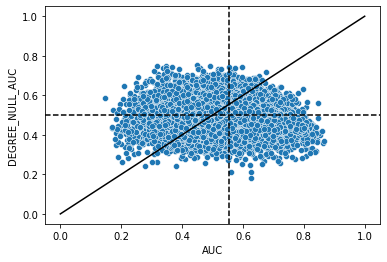

In [62]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [47]:
df_2d_jac['AUC'].mean()

0.5637896331194727

In [63]:
df_t = df_2d_jac.merge(df_gene_tp_sel.sum().reset_index(), left_on=df_2d_jac.index, right_on='index')


In [26]:
df_t

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value   index    0
0     0.548648     10432.251330         0.500019  2.071635e-02  177492  147
1     0.593454     10135.578246         0.442564  5.234711e-02  177557   26
2     0.536454     10060.668246         0.407840  2.975338e-01  177565   20
3     0.624543     10300.179106         0.478141  5.764654e-07  177566  127
4     0.461897     10385.444057         0.516128  6.432477e-02  177580  129
...        ...              ...              ...           ...     ...  ...
7876  0.601389     10454.027772         0.510980  1.831122e-08  163474  249
7877  0.560149     10544.321932         0.529888  4.074555e-03  163477  159
7878  0.525629     10027.908366         0.415976  2.571734e-01  163557   60
7879  0.660111     10531.933967         0.498688  3.683678e-03  163562   32
7880  0.692969     10628.637247         0.547172  1.431164e-17  163634  162

[7881 rows x 6 columns]

In [64]:
df_t['quintile'] = pd.qcut(df_t[0] , 10, labels=np.arange(10, 0, -1))



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='AUC'>

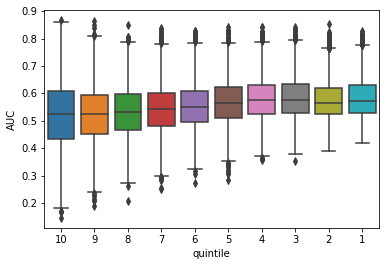

In [65]:
sns.boxplot(df_t['quintile'], df_t['AUC'])



In [34]:
kl

NameError: name 'kl' is not defined

In [31]:
df_t[df_t['quintile'] == 1]

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value   index     0  \
5     0.616393     10677.110581         0.574954   2.229388e-68  177591  1983   
14    0.663389     10572.340811         0.544111  9.583433e-105  177716  1536   
15    0.707153     10588.845815         0.539716  5.304060e-174  177731  1604   
18    0.707478     10582.908973         0.541711  2.018835e-234  177735  2206   
23    0.598158     10705.317871         0.588670   2.556946e-63  177763  2636   
...        ...              ...              ...            ...     ...   ...   
7761  0.642280     10809.833624         0.610719  2.569722e-122  156954  2442   
7766  0.526470     10515.706432         0.529004   6.451476e-04  156996  1277   
7769  0.518803     10666.100079         0.577176   8.463337e-04  157089  2503   
7774  0.577206     10723.243349         0.591732   8.175634e-38  157163  2467   
7778  0.702113     10578.250368         0.537783  3.649385e-188  157217  1839   

     quintile  
5           1  
14          1  
15          1  
18          1  
23          1  
...       ...  
7761        1  
7766        1  
7769        1  
7774        1  
7778        1  

[787 rows x 7 columns]

In [ ]:
kl